In [652]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

In [565]:
season_2020 = pd.read_csv('data/2020_season.txt')

In [566]:
cleaned_2020 = season_2020.drop(columns = ['Start (ET)','Unnamed: 6','Unnamed: 7','Attend.','Notes'])
cleaned_2020 = cleaned_2020.rename(columns={'Visitor/Neutral':'Visitor Team','Home/Neutral':'Home Team','PTS':'Visitor Pts','PTS.1':'Home Pts'})
cleaned_2020.head()

,Date,Visitor Team,Visitor Pts,Home Team,Home Pts
0,Tue Dec 22 2020,Golden State Warriors,99,Brooklyn Nets,125
1,Tue Dec 22 2020,Los Angeles Clippers,116,Los Angeles Lakers,109
2,Wed Dec 23 2020,Charlotte Hornets,114,Cleveland Cavaliers,121
3,Wed Dec 23 2020,New York Knicks,107,Indiana Pacers,121
4,Wed Dec 23 2020,Miami Heat,107,Orlando Magic,113


In [567]:
team_stats = pd.read_csv('data/teams_stats.csv')

In [568]:
team_stats = team_stats.dropna(how='all')
team_stats.head()

,Eastern Conference,W,L,W/L%,GB,PS/G,PA/G,SRS,Western Conference,W.1,L.1,W/L%.1,GB.1,PS/G.1,PA/G.1,SRS.1
0,Milwaukee Bucks,56.0,17.0,0.767,—,118.7,108.6,9.41,Los Angeles Lakers,52.0,19.0,0.732,—,113.4,107.6,6.28
1,Toronto Raptors,53.0,19.0,0.736,2.5,112.8,106.5,5.97,Los Angeles Clippers,49.0,23.0,0.681,3.5,116.3,109.9,6.66
2,Boston Celtics,48.0,24.0,0.667,7.5,113.7,107.3,5.83,Denver Nuggets,46.0,27.0,0.630,7,111.3,109.2,2.35
3,Indiana Pacers,45.0,28.0,0.616,11,109.4,107.5,1.63,Houston Rockets,44.0,28.0,0.611,8.5,117.8,114.8,3.13
4,Miami Heat,44.0,29.0,0.603,12,112.0,109.1,2.59,Oklahoma City Thunder,44.0,28.0,0.611,8.5,110.4,108.4,2.33


In [569]:
team = []
odds = []
for i in range(len(team_stats.count())-1):
    team.append(team_stats.at[i,'Eastern Conference'])
    odds.append(team_stats.at[i,'W/L%'])
    team.append(team_stats.at[i,'Western Conference'])
    odds.append(team_stats.at[i,'W/L%.1'])

In [570]:
trad_odd_dict = {
    'Team': team,
    'Odds': odds
}
traditions_odds_df = pd.DataFrame(trad_odd_dict)

In [571]:
traditions_odds_df.head()

,Team,Odds
0,Milwaukee Bucks,0.767
1,Los Angeles Lakers,0.732
2,Toronto Raptors,0.736
3,Los Angeles Clippers,0.681
4,Boston Celtics,0.667


In [572]:
x = traditions_odds_df.loc[traditions_odds_df['Team'] == 'Milwaukee Bucks','Odds']

In [573]:
games = pd.read_csv('data/simple_2019season.csv')

In [574]:
trad_analysis = cleaned_2020

In [575]:
likely_win = []
actual_win = []
for i in range(len(trad_analysis.index)):
    visitor_team = trad_analysis.at[i,'Visitor Team']
    home_team = trad_analysis.at[i,'Home Team']
    vis_odds = traditions_odds_df.loc[traditions_odds_df['Team'] == visitor_team,:].reset_index()
    home_odds = traditions_odds_df.loc[traditions_odds_df['Team'] == home_team,:].reset_index()
    if (vis_odds['Odds'].item() > home_odds['Odds'].item()):
        likely_win.append(visitor_team)
    elif (home_odds['Odds'].item() > vis_odds['Odds'].item()):
        likely_win.append(home_team)
    elif (home_odds['Odds'].item() == vis_odds['Odds'].item()):
        likely_win.append('Tie')
    else:
        likely_win.append(' ')
    visitor_pts = trad_analysis.at[i,'Visitor Pts']
    home_pts = trad_analysis.at[i,'Home Pts']
    if (visitor_pts > home_pts):
        actual_win.append(visitor_team)
    elif (home_pts > visitor_pts):
        actual_win.append(home_team)
    elif (home_pts == visitor_pts):
        actual_win.append('Tie')
    else:
        actual_win.append(' ')

In [576]:
trad_analysis['Likely to Win'] = likely_win

In [577]:
trad_analysis['Actual Win'] = actual_win

In [578]:
trad_odds_count = 0
for i in range(len(trad_analysis.index)):
    if (trad_analysis.at[i,'Likely to Win'] == trad_analysis.at[i,'Actual Win']):
        trad_odds_count = trad_odds_count + 1

In [579]:
trad_odds_count

176

**Ridge Analysis**

In [583]:
games_temp = pd.read_csv('data/simple_2019season.csv')

In [584]:
games_temp['Pts Difference'] = games_temp['Home Pts'] - games_temp['Visitor Pts']

In [585]:
games_temp['Home Win'] = np.where(games_temp['Pts Difference'] > 0,1,0)
games_temp['Home Loss'] = np.where(games_temp['Pts Difference'] < 0,1,0)

In [586]:
df_visitor = pd.get_dummies(games_temp['Visitor Team'],dtype=np.int64)
df_home = pd.get_dummies(games_temp['Home Team'],dtype=np.int64)

In [587]:
df_model = df_home.sub(df_visitor)
df_model['Pts Difference'] = games_temp['Pts Difference']

In [588]:
df_train = df_model

In [589]:
lr = Ridge(alpha=0.001)
x = df_train.drop(['Pts Difference'], axis=1)
y = df_train['Pts Difference']

lr.fit(x,y)

Ridge(alpha=0.001)

In [590]:
df_ratings = pd.DataFrame(data={'Team': x.columns,'ratings':lr.coef_})

In [591]:
df_ratings

,Team,ratings
0,Atlanta Hawks,-7.565616
1,Boston Celtics,6.658404
2,Brooklyn Nets,-1.492716
3,Charlotte Hornets,-6.814215
4,Chicago Bulls,-4.010651
5,Cleveland Cavaliers,-7.809751
6,Dallas Mavericks,4.479577
7,Denver Nuggets,2.678716
8,Detroit Pistons,-4.287864
9,Golden State Warriors,-8.016180


In [593]:
ridge_analysis = season_2020.drop(columns = ['Start (ET)','Unnamed: 6','Unnamed: 7','Attend.','Notes'])
ridge_analysis = ridge_analysis.rename(columns={'Visitor/Neutral':'Visitor Team','Home/Neutral':'Home Team','PTS':'Visitor Pts','PTS.1':'Home Pts'})
ridge_analysis.head()

,Date,Visitor Team,Visitor Pts,Home Team,Home Pts
0,Tue Dec 22 2020,Golden State Warriors,99,Brooklyn Nets,125
1,Tue Dec 22 2020,Los Angeles Clippers,116,Los Angeles Lakers,109
2,Wed Dec 23 2020,Charlotte Hornets,114,Cleveland Cavaliers,121
3,Wed Dec 23 2020,New York Knicks,107,Indiana Pacers,121
4,Wed Dec 23 2020,Miami Heat,107,Orlando Magic,113


In [594]:
ridge_likely_win = []
ridge_actual_win = []
for i in range(len(ridge_analysis.index)):
    visitor_team = ridge_analysis.at[i,'Visitor Team']
    home_team = ridge_analysis.at[i,'Home Team']
    vis_odds = df_ratings.loc[df_ratings['Team'] == visitor_team,:].reset_index()
    home_odds = df_ratings.loc[df_ratings['Team'] == home_team,:].reset_index()
    if (vis_odds['ratings'].item() > home_odds['ratings'].item()):
        ridge_likely_win.append(visitor_team)
    elif (home_odds['ratings'].item() > vis_odds['ratings'].item()):
        ridge_likely_win.append(home_team)
    elif (home_odds['ratings'].item() == vis_odds['ratings'].item()):
        ridge_likely_win.append('Tie')
    else:
        ridge_likely_win.append(' ')
    visitor_pts = ridge_analysis.at[i,'Visitor Pts']
    home_pts = ridge_analysis.at[i,'Home Pts']
    if (visitor_pts > home_pts):
        ridge_actual_win.append(visitor_team)
    elif (home_pts > visitor_pts):
        ridge_actual_win.append(home_team)
    elif (home_pts == visitor_pts):
        ridge_actual_win.append('Tie')
    else:
        ridge_actual_win.append(' ')

In [595]:
ridge_analysis['Likely to Win'] = ridge_likely_win

In [596]:
ridge_analysis['Actual Win'] = ridge_actual_win

In [597]:
ridge_odds_count = 0
for i in range(len(ridge_analysis.index)):
    if (ridge_analysis.at[i,'Likely to Win'] == ridge_analysis.at[i,'Actual Win']):
        ridge_odds_count = ridge_odds_count + 1

In [598]:
ridge_odds_count

180

**Home Team Win Analysis**

In [599]:
home_team_analysis = season_2020.drop(columns = ['Start (ET)','Unnamed: 6','Unnamed: 7','Attend.','Notes'])
home_team_analysis = home_team_analysis.rename(columns={'Visitor/Neutral':'Visitor Team','Home/Neutral':'Home Team','PTS':'Visitor Pts','PTS.1':'Home Pts'})
home_team_analysis

,Date,Visitor Team,Visitor Pts,Home Team,Home Pts
0,Tue Dec 22 2020,Golden State Warriors,99,Brooklyn Nets,125
1,Tue Dec 22 2020,Los Angeles Clippers,116,Los Angeles Lakers,109
2,Wed Dec 23 2020,Charlotte Hornets,114,Cleveland Cavaliers,121
3,Wed Dec 23 2020,New York Knicks,107,Indiana Pacers,121
4,Wed Dec 23 2020,Miami Heat,107,Orlando Magic,113
...,...,...,...,...,...
309,Wed Feb 3 2021,Washington Wizards,103,Miami Heat,100
310,Wed Feb 3 2021,Houston Rockets,87,Oklahoma City Thunder,104
311,Wed Feb 3 2021,Minnesota Timberwolves,108,San Antonio Spurs,111
312,Wed Feb 3 2021,Phoenix Suns,101,New Orleans Pelicans,123


In [600]:
home_team_analysis['Likely to Win'] = home_team_analysis['Home Team']

In [601]:
home_team_analysis['Actual Win'] = ridge_analysis['Actual Win']

In [602]:
ht_odds_count = 0
for i in range(len(home_team_analysis.index)):
    if (home_team_analysis.at[i,'Likely to Win'] == home_team_analysis.at[i,'Actual Win']):
        ht_odds_count = ht_odds_count + 1

In [603]:
ht_odds_count

162

**Goal difference with home advantage**

In [605]:
gdha_analysis = season_2020.drop(columns = ['Start (ET)','Unnamed: 6','Unnamed: 7','Attend.','Notes'])
gdha_analysis = gdha_analysis.rename(columns={'Visitor/Neutral':'Visitor Team','Home/Neutral':'Home Team','PTS':'Visitor Pts','PTS.1':'Home Pts'})
gdha_analysis.head()

,Date,Visitor Team,Visitor Pts,Home Team,Home Pts
0,Tue Dec 22 2020,Golden State Warriors,99,Brooklyn Nets,125
1,Tue Dec 22 2020,Los Angeles Clippers,116,Los Angeles Lakers,109
2,Wed Dec 23 2020,Charlotte Hornets,114,Cleveland Cavaliers,121
3,Wed Dec 23 2020,New York Knicks,107,Indiana Pacers,121
4,Wed Dec 23 2020,Miami Heat,107,Orlando Magic,113


In [606]:
#total games played by each team
visitor_ct = games['Visitor Team'].value_counts().to_frame()
home_ct = games['Home Team'].value_counts().to_frame()

In [607]:
visitor_ct = visitor_ct.rename(columns = {'Visitor Team':'Games'})
home_ct = home_ct.rename(columns = {'Home Team':'Games'})

In [608]:
visitor_ct['Team'] = visitor_ct.index

In [609]:
home_ct['Team'] = home_ct.index

In [610]:
game_ct = visitor_ct.merge(home_ct,on='Team')

In [611]:
game_ct['Total'] = game_ct['Games_x']+game_ct['Games_y']

In [612]:
game_ct = game_ct.drop(columns=['Games_x','Games_y'])
game_ct

,Team,Total
0,Miami Heat,94
1,Denver Nuggets,92
2,Boston Celtics,89
3,Los Angeles Lakers,92
4,Houston Rockets,84
5,Milwaukee Bucks,83
6,Los Angeles Clippers,85
7,Toronto Raptors,83
8,Orlando Magic,78
9,Utah Jazz,79


In [613]:
scored_pts = []
allowed_pts = []
for i in range(len(team)):
    temp = team[i]
    spts = 0
    apts = 0
    for j in range(len(games.index)):
        if (games.at[j,'Visitor Team'] == temp):
            spts = spts+(games.at[j,'Visitor Pts'])
            apts = apts+(games.at[j,'Home Pts'])
        elif (games.at[j,'Home Team'] == temp):
            spts = spts+(games.at[j,'Home Pts'])
            apts = apts+(games.at[j,'Visitor Pts'])
    scored_pts.append(spts)
    allowed_pts.append(apts)

In [614]:
game_ct['Scored Pts'] = scored_pts
game_ct['Allowed_Pts'] = allowed_pts

In [615]:
game_ct['Team Goal Difference'] = (game_ct['Scored Pts']-game_ct['Allowed_Pts'])/game_ct['Total']

In [616]:
game_ct.head()

,Team,Total,Scored Pts,Allowed_Pts,Team Goal Difference
0,Miami Heat,94,9774,9026,7.957447
1,Denver Nuggets,92,10423,9868,6.032609
2,Boston Celtics,89,9321,8827,5.550562
3,Los Angeles Lakers,92,9859,9340,5.641304
4,Houston Rockets,84,10042,9503,6.416667


In [617]:
#home advantage goal difference 
hagd = (games['Home Pts'].sum() - games['Visitor Pts'].sum())/games['Date'].count()

In [618]:
margin = []
gdha_likely_win = []
for i in range(len(gdha_analysis.index)):
    vn = gdha_analysis.at[i,'Visitor Team']
    v_hold = game_ct['Team Goal Difference'][game_ct['Team'] == vn].to_frame()
    vptsd = v_hold['Team Goal Difference'].item()
    hn = gdha_analysis.at[i,'Home Team']
    h_hold= game_ct['Team Goal Difference'][game_ct['Team'] == hn].to_frame()
    hptsd = h_hold['Team Goal Difference'].item()
    margin_h = (vptsd-hptsd)/hagd
    margin.append(margin_h)
    if (margin_h > 0):
        gdha_likely_win.append(vn)
    elif (margin_h < 0):
        gdha_likely_win.append(hn)

In [619]:
gdha_analysis['Likely to Win'] = gdha_likely_win

In [620]:
gdha_analysis['Margin'] = margin

In [621]:
gdha_analysis['Actual Win'] = ridge_analysis['Actual Win'] 

In [622]:
gdha_analysis.head()

,Date,Visitor Team,Visitor Pts,Home Team,Home Pts,Likely to Win,Margin,Actual Win
0,Tue Dec 22 2020,Golden State Warriors,99,Brooklyn Nets,125,Brooklyn Nets,-1.203790,Brooklyn Nets
1,Tue Dec 22 2020,Los Angeles Clippers,116,Los Angeles Lakers,109,Los Angeles Lakers,-2.172368,Los Angeles Clippers
2,Wed Dec 23 2020,Charlotte Hornets,114,Cleveland Cavaliers,121,Charlotte Hornets,3.655018,Cleveland Cavaliers
3,Wed Dec 23 2020,New York Knicks,107,Indiana Pacers,121,Indiana Pacers,-3.069566,Indiana Pacers
4,Wed Dec 23 2020,Miami Heat,107,Orlando Magic,113,Miami Heat,2.274572,Orlando Magic


In [623]:
gdha_odds_count = 0
for i in range(len(gdha_analysis.index)):
    if (gdha_analysis.at[i,'Likely to Win'] == gdha_analysis.at[i,'Actual Win']):
        gdha_odds_count = gdha_odds_count + 1

In [624]:
gdha_odds_count

166

In [625]:
odds_dict = {
    'Win-Loss%' : trad_odds_count,
    'Home Team Win': ht_odds_count,
    'Goal Difference with Home Advantage': gdha_odds_count,
    'Ridge Regression': ridge_odds_count
}

In [626]:
odds_df = pd.DataFrame(odds_dict, index=['# of Correctly Predicted Games'])

In [627]:
odds = odds_df.T

In [628]:
odds['Percent of Correctly Predicted Games'] = (odds['# of Correctly Predicted Games']/314)*100

In [663]:
odds_bar = odds.drop(columns=['# of Correctly Predicted Games'])

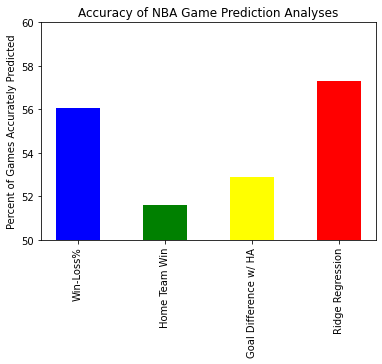

In [698]:
plt.bar(x=odds_bar.index,height=odds_bar['Percent of Correctly Predicted Games'],width=0.5,color=['blue','green','yellow','red'])
plt.xticks(ticks=[0,1,2,3],labels=['Win-Loss%','Home Team Win','Goal Difference w/ HA','Ridge Regression'],rotation='vertical')
plt.ylim((50,60))
plt.ylabel('Percent of Games Accurately Predicted')
plt.title('Accuracy of NBA Game Prediction Analyses')
plt.savefig('cut_bar.png')
plt.show()

In [661]:
odds_bar

,index,Win-Loss%,Home Team Win,Goal Difference with Home Advantage,Ridge Regression
0,Percent of Correctly Predicted Games,56.050955,51.592357,52.866242,57.324841
